<a href="https://colab.research.google.com/github/Dererkzzz/ECE1512-2023F-ProjectRepo-Longqian-Zhang-Yuxuan-Liu/blob/main/ProjectA/Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow.compat.v2 as tf
from typing import Union
from tensorflow.keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.utils as utils
import keras
import numpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from IPython.display import Image, display
from google.colab import drive
import os
tf.enable_v2_behavior()

In [2]:
drive.mount('/content/drive')
target_directory = r'/content/drive/My Drive/ECE_1512_ProjectA/mhist_dataset/images'
os.chdir(target_directory)
image_table = pd.read_csv('/content/drive/My Drive/ECE_1512_ProjectA/mhist_dataset/annotations.csv')

Mounted at /content/drive


#train/test dataset


In [3]:
train_set = image_table[image_table['Partition'] == 'train']
test_set = image_table[image_table['Partition'] == 'test']


In [4]:
image_dir = '/content/drive/My Drive//ECE_1512_ProjectA/mhist_dataset/images'

In [5]:
# data augmentation
train_set_augmentation = ImageDataGenerator(
    rescale=1/255.0,
    shear_range=-0.1,
    rotation_range=15,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2
)

test_set_augmentation = ImageDataGenerator(
    rescale=1/255.0
)

#Create dataset generator

In [6]:
train_set_create = train_set_augmentation.flow_from_dataframe(
    dataframe=train_set,
    directory=image_dir,
    x_col="Image Name",
    y_col="Majority Vote Label",
    batch_size=32,
    seed=50,
    shuffle=True,
    interpolation='lanczos',
    class_mode="categorical",
    target_size=(224, 224)
)

Found 2175 validated image filenames belonging to 2 classes.


In [7]:
test_set_create = test_set_augmentation.flow_from_dataframe(
    dataframe=test_set,
    directory=image_dir,
    x_col="Image Name",
    y_col="Majority Vote Label",
    batch_size=32,
    seed=50,
    shuffle=False,
    interpolation='lanczos',
    class_mode="categorical",
    target_size=(224, 224)
)

Found 977 validated image filenames belonging to 2 classes.


#Create ResNet50v2 model

In [8]:
resnet = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling='avg'
)

# freeze some layers to reduce calcuate time
freeze_layers = 160
for layer in resnet.layers[:freeze_layers]:
    layer.trainable = False

94668760/94668760 [==============================] - 1s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23568898 (89.91 MB)
Trainable params: 14447618 (55.11 MB)
Non-trainable params: 9121280 (34.79 MB)
_________________________________________________________________


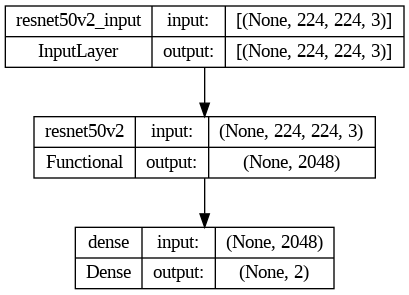

In [9]:
# add dense layer for class 2
output_layer = tf.keras.layers.Dense(units=2, activation='linear')

teacher_res = tf.keras.Sequential([resnet, output_layer])
teacher_res.summary()
file_path = 'teacher_res_model.png'
tf.keras.utils.plot_model(teacher_res, to_file=file_path, show_shapes=True, show_layer_names=True)
display(Image(filename=file_path))

#Create mobilenet model

In [10]:
mobilenet = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling='max'
)

9406464/9406464 [==============================] - 0s 0us/step


In [11]:
count=0
for layers in mobilenet.layers:
  count+=1
  if count> 130:
    layers.trainable=True
  else:
    layers.trainable=False


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dense_1 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 1362562 (5.20 MB)
Non-trainable params: 897984 (3.43 MB)
_________________________________________________________________


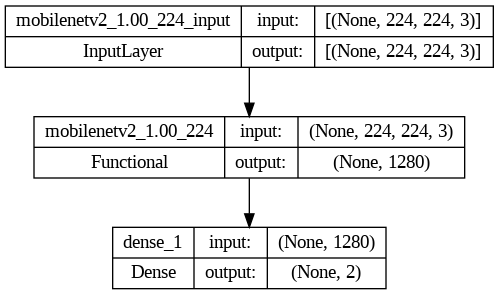

In [12]:
output_layer = tf.keras.layers.Dense(units=2, activation='linear')

# 创建学生模型
student_mobile = tf.keras.Sequential([mobilenet, output_layer])
student_mobile.summary()
file_path = 'student_mobile_modle.png'
tf.keras.utils.plot_model(student_mobile, to_file=file_path, show_shapes=True, show_layer_names=True)
display(Image(filename=file_path))

# Teacher loss function

In [13]:
def compute_teacher_loss(images, labels):

  subclass_logits = teacher_res(images, training=True)
  # Compute cross-entropy loss for subclasses.
  # your code start from here for step 3
  cross_entropy_loss_value = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(labels, subclass_logits)

  return cross_entropy_loss_value

# Student loss function

In [14]:
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):

 # your code start from here for step 3
  soft_targets = tf.nn.softmax(teacher_logits/temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels, ALPHA, DISTILLATION_TEMPERATURE):

  student_subclass_logits = student_mobile(images, training=True)
  teacher_subclass_logits = teacher_res(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits,
                      DISTILLATION_TEMPERATURE)
  cross_entropy_loss_value = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(labels, student_subclass_logits)

  return ALPHA * distillation_loss_value + (1-ALPHA)* cross_entropy_loss_value

# Train and evaluation


In [15]:
def compute_num_correct(model, images, labels):

  class_logits = model(images, training=False)

  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)

AUC function

In [16]:
def compute_auc(model, generator):
    predictions = []
    ground_truth = []

    for _ in range(31):
        images, labels = generator.next()
        logits = model(images, training=False)
        probabilities = tf.nn.softmax(logits, axis=-1)
        predictions.extend(probabilities.numpy())
        ground_truth.extend(labels)
    auc = roc_auc_score(ground_truth, predictions, multi_class='ovr')

    return auc

In [24]:
def train_and_evaluate_teacher(model, compute_loss_fn):

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
  for epoch in range(1, 10 + 1):
    print('Epoch {}: '.format(epoch), end='')
    train_set_create.reset()

    # range(68) bacause the num of image in train dataset
    for _ in range(68):
      images, labels = train_set_create.next()
      with tf.GradientTape() as tape:
        loss_value = compute_loss_fn(images, labels)
      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    num_correct = 0
    num_total = 0

    # range(31) bacause the num of image in test dataset
    for _ in range(31):
      images, labels = test_set_create.next()
      num_total += len(labels)
      num_correct += compute_num_correct(model, images, labels)[0]
    auc = compute_auc(model, test_set_create)
    #print("Class accuracy: " + '{:.2f}%'.format(num_correct / num_total * 100))
    print("AUC: {:.4f}".format(auc))

  # Fine-tuning phase.
  print('Fine-tuning')
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
  for epoch in range(1, 25 + 1):
    print('Epoch {}: '.format(epoch), end='')
    train_set_create.reset()

    for _ in range(68):
      images, labels = train_set_create.next()
      with tf.GradientTape() as tape:
        loss_value = compute_loss_fn(images, labels)
      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    num_correct = 0
    num_total = 0
    for _ in range(31):
      images, labels = test_set_create.next()
      num_total += len(labels)
      num_correct += compute_num_correct(model, images, labels)[0]
    auc = compute_auc(model, test_set_create)
    #print("Class accuracy: " + '{:.2f}%'.format(num_correct / num_total * 100))
    print("AUC: {:.4f}".format(auc))

In [18]:
def train_and_evaluate_kd(model, compute_loss_fn, ALPHA, DISTILLATION_TEMPERATURE):

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  for epoch in range(1,10 + 1):
    print('Epoch {}: '.format(epoch), end='')
    train_set_create.reset()

    for _ in range(68):
      images, labels=train_set_create.next()
      with tf.GradientTape() as tape:
        loss_value = compute_loss_fn(images,labels, ALPHA, DISTILLATION_TEMPERATURE)
      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    num_correct = 0
    num_total = 0
    for _ in range(31):
      images, labels=test_set_create.next()
      num_total+= len(labels)
      correct_predictions = compute_num_correct(model, images, labels)
      num_correct += correct_predictions[0]
    auc = compute_auc(model, test_set_create)
    #print("Class accuracy: " + '{:.2f}%'.format(num_correct / num_total * 100))
    print("AUC: {:.4f}".format(auc))

  # Fine-tuning phase.
  print('fine tuning')
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

  for epoch in range(1,25+1):
  # Run training.
    print('Epoch {}: '.format(epoch), end='')
    train_set_create.reset()

    for _ in range(68):
      images, labels=train_set_create.next()
      with tf.GradientTape() as tape:
        loss_value = compute_loss_fn(images,labels, ALPHA, DISTILLATION_TEMPERATURE)
      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    num_correct = 0
    num_total = 0
    for _ in range(31):
      images, labels=test_set_create.next()
      num_total+= len(labels)
      correct_predictions = compute_num_correct(model, images, labels)
      num_correct += correct_predictions[0]
    auc = compute_auc(model, test_set_create)
    #print("Class accuracy: " + '{:.2f}%'.format(num_correct / num_total * 100))
    print("AUC: {:.4f}".format(auc))

In [19]:
def train_and_evaluate_no_kd(model, compute_loss_fn):

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  for epoch in range(1,10+1):
    print('Epoch {}: '.format(epoch), end='')
    train_set_create.reset()

    for _ in range(68):
      images, labels=train_set_create.next()
      with tf.GradientTape() as tape:
        loss_value = compute_loss_fn(images,labels)
      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    num_correct = 0
    num_total = 0
    for _ in range(31):
      images, labels=test_set_create.next()
      num_total+= len(labels)
      correct_predictions = compute_num_correct(model, images, labels)
      num_correct += correct_predictions[0]
    auc = compute_auc(model, test_set_create)
    #print("Class accuracy: " + '{:.2f}%'.format(num_correct / num_total * 100))
    print("AUC: {:.4f}".format(auc))

  # Fine-tuning phase.
  print('fine tuning')
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
  for epoch in range(1,25+1):
    print('Epoch {}: '.format(epoch), end='')
    train_set_create.reset()

    for _ in range(68):
      images, labels=train_set_create.next()
      with tf.GradientTape() as tape:
        loss_value = compute_loss_fn(images,labels)
      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    num_correct = 0
    num_total = 0
    for _ in range(31):
      images, labels=test_set_create.next()
      num_total+= len(labels)
      correct_predictions = compute_num_correct(model, images, labels)
      num_correct += correct_predictions[0]
    auc = compute_auc(model, test_set_create)
    #print("Class accuracy: " + '{:.2f}%'.format(num_correct / num_total * 100))
    print("AUC: {:.4f}".format(auc))

In [20]:
def compute_plain_cross_entropy_loss_mobile(images, labels):

  student_subclass_logits = student_mobile(images, training=True)
  cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(labels, student_subclass_logits)

  return cross_entropy_loss

#Training

In [25]:
train_and_evaluate_teacher(teacher_res,compute_teacher_loss) #new

Epoch 1: AUC: 0.9021
Epoch 2: AUC: 0.9099
Epoch 3: AUC: 0.8957
Epoch 4: AUC: 0.9037
Epoch 5: AUC: 0.8912
Epoch 6: AUC: 0.8933
Epoch 7: AUC: 0.9035
Epoch 8: AUC: 0.8885
Epoch 9: AUC: 0.9010
Epoch 10: AUC: 0.8955
Fine-tuning
Epoch 1: AUC: 0.9064
Epoch 2: AUC: 0.9080
Epoch 3: AUC: 0.9059
Epoch 4: AUC: 0.9081
Epoch 5: AUC: 0.9100
Epoch 6: AUC: 0.9090
Epoch 7: AUC: 0.9097
Epoch 8: AUC: 0.9109
Epoch 9: AUC: 0.9076
Epoch 10: AUC: 0.9072
Epoch 11: AUC: 0.9045
Epoch 12: AUC: 0.9051
Epoch 13: AUC: 0.9070
Epoch 14: AUC: 0.9052
Epoch 15: AUC: 0.9044
Epoch 16: AUC: 0.9086
Epoch 17: AUC: 0.9076
Epoch 18: AUC: 0.9083
Epoch 19: AUC: 0.9085
Epoch 20: AUC: 0.9060
Epoch 21: AUC: 0.9073
Epoch 22: AUC: 0.9081
Epoch 23: AUC: 0.9095
Epoch 24: AUC: 0.9101
Epoch 25: AUC: 0.9084


In [28]:
train_and_evaluate_kd(student_mobile, compute_student_loss,0.7,8)

Epoch 1: AUC: 0.7832
Epoch 2: AUC: 0.7737
Epoch 3: AUC: 0.8139
Epoch 4: AUC: 0.8181
Epoch 5: AUC: 0.8300
Epoch 6: AUC: 0.8326
Epoch 7: AUC: 0.8394
Epoch 8: AUC: 0.8850
Epoch 9: AUC: 0.8645
Epoch 10: AUC: 0.8303
fine tuning
Epoch 1: AUC: 0.8622
Epoch 2: AUC: 0.8883
Epoch 3: AUC: 0.8915
Epoch 4: AUC: 0.8918
Epoch 5: AUC: 0.8904
Epoch 6: AUC: 0.8874
Epoch 7: AUC: 0.8828
Epoch 8: AUC: 0.8875
Epoch 9: AUC: 0.8932
Epoch 10: AUC: 0.8887
Epoch 11: AUC: 0.8931
Epoch 12: AUC: 0.8978
Epoch 13: AUC: 0.8854
Epoch 14: AUC: 0.8923
Epoch 15: AUC: 0.8878
Epoch 16: AUC: 0.8930
Epoch 17: AUC: 0.8873
Epoch 18: AUC: 0.8902
Epoch 19: AUC: 0.8913
Epoch 20: AUC: 0.8807
Epoch 21: AUC: 0.8920
Epoch 22: AUC: 0.8937
Epoch 23: AUC: 0.8878
Epoch 24: AUC: 0.8902
Epoch 25: AUC: 0.8927


In [29]:
train_and_evaluate_no_kd(student_mobile, compute_plain_cross_entropy_loss_mobile)

Epoch 1: AUC: 0.8315
Epoch 2: AUC: 0.8576
Epoch 3: AUC: 0.8485
Epoch 4: AUC: 0.8068
Epoch 5: AUC: 0.7482
Epoch 6: AUC: 0.8227
Epoch 7: AUC: 0.8022
Epoch 8: AUC: 0.7689
Epoch 9: AUC: 0.8346
Epoch 10: AUC: 0.8270
fine tuning
Epoch 1: AUC: 0.8403
Epoch 2: AUC: 0.8494
Epoch 3: AUC: 0.8620
Epoch 4: AUC: 0.8589
Epoch 5: AUC: 0.8595
Epoch 6: AUC: 0.8568
Epoch 7: AUC: 0.8550
Epoch 8: AUC: 0.8427
Epoch 9: AUC: 0.8498
Epoch 10: AUC: 0.8553
Epoch 11: AUC: 0.8512
Epoch 12: AUC: 0.8593
Epoch 13: AUC: 0.8631
Epoch 14: AUC: 0.8647
Epoch 15: AUC: 0.8635
Epoch 16: AUC: 0.8612
Epoch 17: AUC: 0.8701
Epoch 18: AUC: 0.8770
Epoch 19: AUC: 0.8688
Epoch 20: AUC: 0.8710
Epoch 21: AUC: 0.8693
Epoch 22: AUC: 0.8659
Epoch 23: AUC: 0.8647
Epoch 24: AUC: 0.8649
Epoch 25: AUC: 0.8637


## Student test accuracy vs temperature


In [ ]:
temps = [1, 2, 4, 16, 32, 64]
ALPHA = 0.5
auc_scores = []

for i in range(6):

    print('temp=', temps[i])
    DISTILLATION_TEMPERATURE = temps[i]
    train_and_evaluate_kd(student_mobile, compute_student_loss, ALPHA, DISTILLATION_TEMPERATURE)
    y_pred_o = student_mobile.predict(test_set_create, verbose=1)

    # Calculate AUC
    auc = compute_auc(student_mobile, test_set_create)
    auc_scores.append(auc)
    print("Evaluating the student with KD")
    print('AUC: ', auc)

for i, temp in enumerate(temps):
    print(f'Temperature {temp} - AUC: {auc_scores[i]}')

temp= 1
Epoch 1: 

Class accuracy: 63.05%
AUC: 0.6615
Epoch 2: Class accuracy: 52.71%
AUC: 0.6822
Epoch 3: Class accuracy: 42.89%
AUC: 0.6396
Epoch 4: Class accuracy: 66.22%
AUC: 0.7271
Epoch 5: Class accuracy: 60.39%
AUC: 0.6119
Epoch 6: Class accuracy: 66.22%
AUC: 0.7052
Epoch 7: Class accuracy: 68.78%
AUC: 0.7860
Epoch 8: Class accuracy: 75.44%
AUC: 0.8108
Epoch 9: Class accuracy: 76.66%
AUC: 0.8172
Epoch 10: Class accuracy: 79.43%
AUC: 0.8475
fine tuning
Epoch 1: Class accuracy: 75.44%
AUC: 0.8192
Epoch 2: Class accuracy: 74.21%
AUC: 0.8139
Epoch 3: Class accuracy: 75.84%
AUC: 0.8233
Epoch 4: Class accuracy: 77.89%
AUC: 0.8067
Epoch 5: Class accuracy: 75.13%
AUC: 0.8159
Epoch 6: Class accuracy: 73.08%
AUC: 0.7701
Epoch 7: Class accuracy: 72.98%
AUC: 0.7871
Epoch 8: Class accuracy: 70.52%
AUC: 0.7482
Epoch 9: Class accuracy: 75.33%
AUC: 0.7848
Epoch 10: Class accuracy: 72.98%
AUC: 0.8155
Epoch 11: Class accuracy: 76.05%
AUC: 0.8225
Epoch 12: Class accuracy: 80.04%
AUC: 0.8410
Epoch 13: Class accuracy:

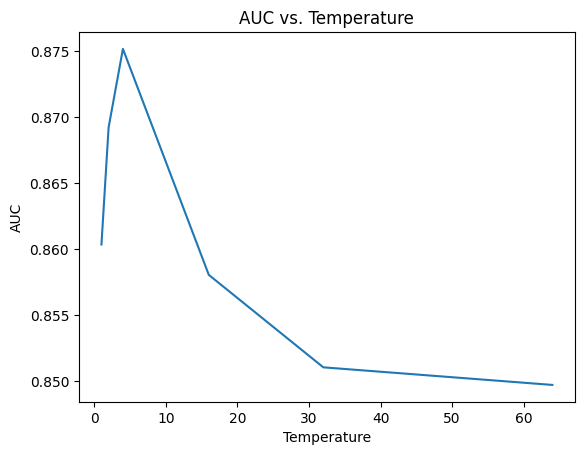

In [ ]:
# Plotting AUC vs. temperature curve
plt.plot(temps, auc_scores)
plt.title('AUC vs. Temperature')
plt.xlabel('Temperature')
plt.ylabel('AUC')
plt.show()


##Comparing the teacher and student model (number of of parameters and FLOPs)

In [ ]:
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

def get_flops(model):

    @tf.function(input_signature=[tf.TensorSpec(shape=(1,) + model.input_shape[1:])])
    def forward_pass(inputs):
        return model(inputs)

    graph_info = profile(forward_pass.get_concrete_function().graph,
                        options=ProfileOptionBuilder.float_operation())

    # Calculate FLOPs (floating-point operations)
    flops = graph_info.total_float_ops // 2

    # Calculate the number of model parameters
    total_params = model.count_params()

    return flops, total_params

In [ ]:
flops_teacher, teacher_totalParams = get_flops(teacher_res)
print('Flops for teacher model: {:,}'.format(flops_teacher))
print('Total Parameters for teacher model: {:,}'.format(teacher_totalParams))

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


Flops for teacher model: 3,484,727,297
Total Parameters for teacher model: 23,568,898


In [ ]:
flops_student, student_totalParams = get_flops(student_mobile)
print('Flops for student model: {:,}'.format(flops_student))
print('Total Parameters for student model: {:,}'.format(student_totalParams))

Flops for student model: 299,496,833
Total Parameters for student model: 2,260,546


#Implementing the state-of-the-art KD algorithm--Improved Knowledge Distillation via Teacher Assistant

In [ ]:
efficientnet = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling='avg'
)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
freeze_layers = 220
for layer in efficientnet.layers[:freeze_layers]:
    layer.trainable = False
print(f"frozen {freeze_layers} layer")

frozen 220 layer


In [ ]:
for idx, layer in enumerate(efficientnet.layers, 1):
    print(f"layer {idx} {layer.trainable},  {layer.name[:15]}")

layer 1 False,  input_3
layer 2 False,  rescaling
layer 3 False,  normalization
layer 4 False,  rescaling_1
layer 5 False,  stem_conv_pad
layer 6 False,  stem_conv
layer 7 False,  stem_bn
layer 8 False,  stem_activation
layer 9 False,  block1a_dwconv
layer 10 False,  block1a_bn
layer 11 False,  block1a_activat
layer 12 False,  block1a_se_sque
layer 13 False,  block1a_se_resh
layer 14 False,  block1a_se_redu
layer 15 False,  block1a_se_expa
layer 16 False,  block1a_se_exci
layer 17 False,  block1a_project
layer 18 False,  block1a_project
layer 19 False,  block2a_expand_
layer 20 False,  block2a_expand_
layer 21 False,  block2a_expand_
layer 22 False,  block2a_dwconv_
layer 23 False,  block2a_dwconv
layer 24 False,  block2a_bn
layer 25 False,  block2a_activat
layer 26 False,  block2a_se_sque
layer 27 False,  block2a_se_resh
layer 28 False,  block2a_se_redu
layer 29 False,  block2a_se_expa
layer 30 False,  block2a_se_exci
layer 31 False,  block2a_project
layer 32 False,  block2a_project
l

In [ ]:
output_layer = tf.keras.layers.Dense(units=2, activation='sigmoid')

ta_eff = tf.keras.Sequential([efficientnet, output_layer])
ta_eff.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense_2 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 4,052,133
Trainable params: 1,131,954
Non-trainable params: 2,920,179
_________________________________________________________________


In [ ]:
def compute_ta_loss(images, labels, ALPHA, DISTILLATION_TEMPERATURE):

  ta_subclass_logits = ta_eff(images, training=True)
  teacher_subclass_logits = teacher_res(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits, ta_subclass_logits,
                      DISTILLATION_TEMPERATURE)
  cross_entropy_loss_value = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(labels, ta_subclass_logits)

  return ALPHA * distillation_loss_value + (1-ALPHA)* cross_entropy_loss_value

def compute_student_loss(images, labels, ALPHA, DISTILLATION_TEMPERATURE):

  student_subclass_logits = student_mobile(images, training=True)
  ta_subclass_logits = ta_eff(images, training=False)
  distillation_loss_value = distillation_loss(ta_subclass_logits, student_subclass_logits,
                      DISTILLATION_TEMPERATURE)
  cross_entropy_loss_value = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(labels, student_subclass_logits)

  return ALPHA * distillation_loss_value + (1-ALPHA)* cross_entropy_loss_value

In [ ]:
def train_and_evaluate_ta(model, compute_loss_fn, ALPHA, DISTILLATION_TEMPERATURE):

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  for epoch in range(1,10+1):
    print('Epoch {}: '.format(epoch), end='')
    train_set_create.reset()

    for _ in range(68):
      images, labels=train_set_create.next()
      with tf.GradientTape() as tape:
        loss_value = compute_loss_fn(images,labels, ALPHA, DISTILLATION_TEMPERATURE)
      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    num_correct = 0
    num_total = 0
    for _ in range(31):
      images, labels=test_set_create.next()
      num_total+= len(labels)
      correct_predictions = compute_num_correct(model, images, labels)
      num_correct += correct_predictions[0]
    auc = compute_auc(model, test_set_create)
    print("Class accuracy: " + '{:.5f}%'.format(num_correct / num_total * 100))
    print("AUC: {:.4f}".format(auc))

  # Fine-tuning phase.
  print('Fine-tuning')
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

  for epoch in range(1,26):
    print('Epoch {}: '.format(epoch), end='')
    train_set_create.reset()
    for _ in range(68):
      images, labels=train_set_create.next()
      with tf.GradientTape() as tape:
        loss_value = compute_loss_fn(images,labels, ALPHA, DISTILLATION_TEMPERATURE)
      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    num_correct = 0
    num_total = 0
    for _ in range(31):
      images, labels=test_set_create.next()
      num_total+= len(labels)
      correct_predictions = compute_num_correct(model, images, labels)
      num_correct += correct_predictions[0]
    auc = compute_auc(model, test_set_create)
    print("Class accuracy: " + '{:.5f}%'.format(num_correct / num_total * 100))
    print("AUC: {:.4f}".format(auc))

In [ ]:
train_and_evaluate_teacher(teacher_res,compute_teacher_loss)

Epoch 1: 

Class accuracy: 79.43%
AUC: 0.8660
Epoch 2: Class accuracy: 81.06%
AUC: 0.8919
Epoch 3: Class accuracy: 81.99%
AUC: 0.8884
Epoch 4: Class accuracy: 82.60%
AUC: 0.8950
Epoch 5: Class accuracy: 82.50%
AUC: 0.9077
Epoch 6: Class accuracy: 83.11%
AUC: 0.8991
Epoch 7: Class accuracy: 82.50%
AUC: 0.8973
Epoch 8: Class accuracy: 82.91%
AUC: 0.9015
Epoch 9: Class accuracy: 82.91%
AUC: 0.8979
Epoch 10: Class accuracy: 82.19%
AUC: 0.8982
Fine-tuning
Epoch 1: Class accuracy: 85.06%
AUC: 0.9080
Epoch 2: Class accuracy: 85.06%
AUC: 0.9115
Epoch 3: Class accuracy: 85.57%
AUC: 0.9133
Epoch 4: Class accuracy: 85.26%
AUC: 0.9129
Epoch 5: Class accuracy: 85.06%
AUC: 0.9126
Epoch 6: Class accuracy: 85.67%
AUC: 0.9139
Epoch 7: Class accuracy: 86.08%
AUC: 0.9134
Epoch 8: Class accuracy: 85.77%
AUC: 0.9135
Epoch 9: Class accuracy: 85.26%
AUC: 0.9102
Epoch 10: Class accuracy: 85.77%
AUC: 0.9125
Epoch 11: Class accuracy: 85.36%
AUC: 0.9124
Epoch 12: Class accuracy: 85.47%
AUC: 0.9113
Epoch 13: Class accuracy:

In [ ]:
train_and_evaluate_ta(ta_eff, compute_ta_loss, 0.7, 8)

Epoch 1: Class accuracy: 63.15251%
AUC: 0.5847
Epoch 2: Class accuracy: 63.15251%
AUC: 0.5760
Epoch 3: Class accuracy: 63.15251%
AUC: 0.5752
Epoch 4: Class accuracy: 63.15251%
AUC: 0.5716
Epoch 5: Class accuracy: 63.15251%
AUC: 0.5740
Epoch 6: Class accuracy: 63.15251%
AUC: 0.5732
Epoch 7: Class accuracy: 63.15251%
AUC: 0.5727
Epoch 8: Class accuracy: 63.15251%
AUC: 0.5759
Epoch 9: Class accuracy: 63.15251%
AUC: 0.5750
Epoch 10: Class accuracy: 63.15251%
AUC: 0.5753
fine tuning
Epoch 1: Class accuracy: 63.15251%
AUC: 0.5768
Epoch 2: Class accuracy: 63.15251%
AUC: 0.5769
Epoch 3: Class accuracy: 63.15251%
AUC: 0.5769
Epoch 4: Class accuracy: 63.15251%
AUC: 0.5764
Epoch 5: Class accuracy: 63.15251%
AUC: 0.5764
Epoch 6: Class accuracy: 63.15251%
AUC: 0.5775
Epoch 7: Class accuracy: 63.15251%
AUC: 0.5782
Epoch 8: Class accuracy: 63.15251%
AUC: 0.5769
Epoch 9: Class accuracy: 63.15251%
AUC: 0.5763
Epoch 10: Class accuracy: 63.15251%
AUC: 0.5784
Epoch 11: Class accuracy: 63.15251%
AUC: 0.578

In [ ]:
train_and_evaluate_kd(student_mobile, compute_student_loss, 0.7, 8)

Epoch 1: Class accuracy: 62.64%
AUC: 0.5550
Epoch 2: Class accuracy: 61.72%
AUC: 0.5492
Epoch 3: Class accuracy: 62.33%
AUC: 0.5116
Epoch 4: Class accuracy: 61.41%
AUC: 0.5330
Epoch 5: Class accuracy: 59.57%
AUC: 0.5945
Epoch 6: Class accuracy: 53.22%
AUC: 0.6047
Epoch 7: Class accuracy: 56.81%
AUC: 0.6258
Epoch 8: Class accuracy: 60.90%
AUC: 0.6562
Epoch 9: Class accuracy: 62.85%
AUC: 0.6617
Epoch 10: Class accuracy: 62.74%
AUC: 0.6761
fine tuning
Epoch 1: Class accuracy: 63.66%
AUC: 0.6787
Epoch 2: Class accuracy: 65.30%
AUC: 0.7275
Epoch 3: Class accuracy: 67.14%
AUC: 0.7393
Epoch 4: Class accuracy: 67.45%
AUC: 0.7417
Epoch 5: Class accuracy: 66.84%
AUC: 0.7205
Epoch 6: Class accuracy: 66.84%
AUC: 0.7292
Epoch 7: Class accuracy: 64.89%
AUC: 0.7493
Epoch 8: Class accuracy: 66.63%
AUC: 0.7526
Epoch 9: Class accuracy: 64.99%
AUC: 0.7473
Epoch 10: Class accuracy: 64.69%
AUC: 0.7367
Epoch 11: Class accuracy: 67.86%
AUC: 0.7657
Epoch 12: Class accuracy: 69.40%
AUC: 0.7506
Epoch 13: Class 

#Improved Knowledge Distillation via FitNet

In [ ]:
import tensorflow.compat.v2 as tf #
from typing import Union
from tensorflow.keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
#from keras.utils.np_utils import to_categorical
import tensorflow.keras.utils as utils
import keras
import numpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import os

tf.enable_v2_behavior()


load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
target_directory = r'/content/drive/My Drive/ECE_1512_ProjectA/mhist_dataset/images'
os.chdir(target_directory)
image_table=pd.read_csv('/content/drive/My Drive/ECE_1512_ProjectA/mhist_dataset/annotations.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# train dataset
train_set = image_table[image_table['Partition'] == 'train']
print("Shape of the 'train_set' DataFrame:")
print(train_set.shape)
# test dataset
test_set = image_table[image_table['Partition'] == 'test']
print("Shape of the 'test_set' DataFrame:")
print(test_set.shape)

image_dir = '/content/drive/My Drive//ECE_1512_ProjectA/mhist_dataset/images'

Shape of the 'train_set' DataFrame:
(2175, 4)
Shape of the 'test_set' DataFrame:
(977, 4)


Data augmentation

In [ ]:
train_set_augmentation = ImageDataGenerator(
    rescale=1/255.0,
    shear_range=-0.1,
    rotation_range=15,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2
)

test_set_augmentation = ImageDataGenerator(
    rescale=1/255.0
)


In [ ]:
# train
train_set_create = train_set_augmentation.flow_from_dataframe(
    dataframe=train_set,
    directory=image_dir,
    x_col="Image Name",
    y_col="Majority Vote Label",
    batch_size=32,
    seed=50,
    shuffle=True,
    interpolation='lanczos',
    class_mode="categorical",
    target_size=(224, 224)
)

#test
test_set_create = test_set_augmentation.flow_from_dataframe(
    dataframe=test_set,
    directory=image_dir,
    x_col="Image Name",
    y_col="Majority Vote Label",
    batch_size=32,
    seed=50,
    shuffle=False,
    interpolation='lanczos',
    class_mode="categorical",
    target_size=(224, 224)
)


Found 2175 validated image filenames belonging to 2 classes.
Found 977 validated image filenames belonging to 2 classes.


create teacher/student model

In [ ]:
# teacher model
teacher_model_1 = resnet_2 = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet", # pretrain weight
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling='avg'
)

# frozen some layer
freeze_layers = 185 #185
for layer in teacher_model_1.layers[:freeze_layers]:
    layer.trainable = False
teacher_model =tf.keras.Sequential([ teacher_model_1,tf.keras.layers.Dense(units=2, activation='linear')])
# print(f"frozen {freeze_layers} layer")
# for idx, layer in enumerate(teacher_model.layers, 1):
#     print(f"layer {idx} {layer.trainable},  {layer.name[:5]}")
teacher_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense_3 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23,568,898
Trainable params: 1,058,818
Non-trainable params: 22,510,080
_________________________________________________________________


In [ ]:
# find hint layer
hint_layer_index = 190
hint_layer = teacher_model_1.layers[hint_layer_index]
hint_model = tf.keras.Model(inputs=teacher_model_1.input, outputs=hint_layer.output)
# teacher_hint_model = tf.keras.Sequential([ hint_model,tf.keras.layers.Flatten(),tf.keras.layers.Dense(units=2, activation='linear')])
teacher_hint_model = tf.keras.Sequential([ hint_model,tf.keras.layers.Flatten()])
teacher_hint_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 2048)              23564800  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
Total params: 23,564,800
Trainable params: 1,054,720
Non-trainable params: 22,510,080
_________________________________________________________________


In [ ]:
# student model
student_model_1 = mobilenet_2 = tf.keras.applications.MobileNetV2(
    include_top=False,  # 不包括顶层（全连接层）
    weights="imagenet",  # 使用预训练权重
    input_tensor=None,  # 没有指定输入张量，将在模型内部创建
    input_shape=(224, 224, 3),  # 输入图像的形状为 224x224 像素，RGB通道
    pooling='max'
)
count=0
for layers in student_model_1.layers:
  count+=1
  if count> 145:
    layers.trainable=True
  else:
    layers.trainable=False
# print('frozen 130 layer')
# count=0
# for layers in student_model.layers:
#   print(layers.name[0:8],layers.trainable, count)
#   count+=1
student_model=tf.keras.Sequential([ student_model_1,tf.keras.layers.Dense(units=2, activation='linear')])
student_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_4 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 733,122
Non-trainable params: 1,527,424
_________________________________________________________________


In [ ]:
# find guide layer in student model
guided_layer = student_model_1.layers[150]
guided_model = tf.keras.Model(inputs=student_model_1.input, outputs=guided_layer.output)

student_hint_model = tf.keras.Sequential([ guided_model,tf.keras.layers.Flatten(),tf.keras.layers.Dense(units=2048, activation='linear')]) # unit=2
student_hint_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 7, 7, 320)         1843264   
                                                                 
 flatten_1 (Flatten)         (None, 15680)             0         
                                                                 
 dense_5 (Dense)             (None, 2048)              32114688  
                                                                 
Total params: 33,957,952
Trainable params: 32,433,088
Non-trainable params: 1,524,864
_________________________________________________________________


Calcuate loss function and evaluation

In [ ]:
# Function to compute the loss between teacher's activations and student's activations
def compute_distillation_loss(teacher_activations, student_activations):
    return tf.reduce_mean(tf.square(teacher_activations - student_activations))

# Function to compute the fitnet loss
def compute_fitnet_loss_for_batch(batch_data):
    images, _ = batch_data
    teacher_activations = teacher_hint_model(images)
    student_activations = student_hint_model(images)
    return compute_distillation_loss(teacher_activations, student_activations)


In [ ]:
# Function to compute the overall student loss including distillation and cross-entropy loss
def compute_combined_student_loss(images, labels, teacher_hint_model, student_hint_model, ALPHA=0.9):
    student_logits = student_model(images, training=True)
    teacher_logits = teacher_model(images, training=False)

    teacher_activations = teacher_hint_model(images)
    student_activations = student_hint_model(images)

    distillation_loss = compute_distillation_loss(teacher_activations, student_activations)

    # Compute cross-entropy loss with hard targets
    cross_entropy_loss_fn = tf.keras.losses.CategoricalCrossentropy(axis=-1)
    #cross_entropy_loss = cross_entropy_loss_fn(labels, tf.nn.softmax(student_logits, axis=-1))
    cross_entropy_loss = cross_entropy_loss_fn(labels, tf.nn.softmax(student_logits, axis=-1))


    return ALPHA * distillation_loss + (1 - ALPHA) * cross_entropy_loss

In [ ]:
def compute_correct_predictions(model, images, labels):
    """Compute number of correctly classified images in a batch."""
    logits = model(images, training=False)
    predicted_labels = tf.argmax(logits, -1)
    true_labels = tf.argmax(labels, -1)

    correct_predictions = tf.reduce_sum(tf.cast(tf.math.equal(predicted_labels, true_labels), tf.float32))

    return correct_predictions, predicted_labels, true_labels

In [ ]:
def compute_auc(model, generator):
    predictions = []
    ground_truth = []

    for _ in range(31):
        images, labels = generator.next()
        logits = model(images, training=False)
        probabilities = tf.nn.softmax(logits, axis=-1)
        predictions.extend(probabilities.numpy())
        ground_truth.extend(labels)
    auc = roc_auc_score(ground_truth, predictions, multi_class='ovr')

    return auc

In [ ]:
def train_and_evaluate_teacher_student(teacher, student, teacher_hint_model, student_hint_model, loss_fn):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    for epoch in range(1, 11):
        print(f'Epoch {epoch}: ', end='')
        train_set_create.reset()
        for _ in range(68):
            images, labels=train_set_create.next()
            with tf.GradientTape() as tape:
                loss_value = compute_combined_student_loss(images, labels, teacher_hint_model, student_hint_model)
            gradients = tape.gradient(loss_value, student.trainable_variables)
            optimizer.apply_gradients(zip(gradients, student.trainable_variables))

        # Evaluate the model's performance
        total_correct = 0
        #total_samples = builder.info.splits['test'].num_examples
        total_samples = 0
        for _ in range(31):
        #for images, labels in test_set_create:
            images, labels=test_set_create.next()
            total_samples +=len(labels)

            correct_preds = compute_correct_predictions(student, images, labels)[0]
            total_correct += correct_preds
        auc = compute_auc(student, test_set_create)
        #accuracy = (total_correct / total_samples) * 100
        #print(f"Classification Accuracy: {accuracy:.2f}%")
        print("AUC: {:.4f}".format(auc))

    print('fine tuning with learning rate 0.0001')
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

    for epoch in range(1, 26):
        print('Epoch {}: '.format(epoch), end='')
        train_set_create.reset()
        for _ in range(68):
            images, labels=train_set_create.next()
            with tf.GradientTape() as tape:
                loss_value = compute_combined_student_loss(images, labels, teacher_hint_model, student_hint_model)
            gradients = tape.gradient(loss_value, student.trainable_variables)
            optimizer.apply_gradients(zip(gradients, student.trainable_variables))

        # Evaluate the model's performance
        total_correct = 0
        #total_samples = builder.info.splits['test'].num_examples
        total_samples = 0
        for _ in range(31):
        #for images, labels in test_set_create:
            images, labels=test_set_create.next()
            total_samples +=len(labels)

            correct_preds = compute_correct_predictions(student, images, labels)[0]
            total_correct += correct_preds
        auc = compute_auc(student, test_set_create)
        #accuracy = (total_correct / total_samples) * 100
        #print(f"Classification Accuracy: {accuracy:.2f}%")
        print("AUC: {:.4f}".format(auc))

In [ ]:
train_and_evaluate_teacher_student(teacher_model,student_model,teacher_hint_model,student_hint_model, compute_combined_student_loss) #140 180

Epoch 1: 

AUC: 0.6302
Epoch 2: AUC: 0.6477
Epoch 3: AUC: 0.7141
Epoch 4: AUC: 0.7599
Epoch 5: AUC: 0.7815
Epoch 6: AUC: 0.7438
Epoch 7: AUC: 0.8192
Epoch 8: AUC: 0.7362
Epoch 9: AUC: 0.7369
Epoch 10: AUC: 0.8369
fine tuning with learning rate 0.0001
Epoch 1: AUC: 0.8490
Epoch 2: AUC: 0.8455
Epoch 3: AUC: 0.8394
Epoch 4: AUC: 0.8605
Epoch 5: AUC: 0.8619
Epoch 6: AUC: 0.8664
Epoch 7: AUC: 0.8674
Epoch 8: AUC: 0.8210
Epoch 9: AUC: 0.8345
Epoch 10: AUC: 0.8584
Epoch 11: AUC: 0.8773
Epoch 12: AUC: 0.8808
Epoch 13: AUC: 0.8793
Epoch 14: AUC: 0.8585
Epoch 15: AUC: 0.8353
Epoch 16: AUC: 0.8060
Epoch 17: AUC: 0.8660
Epoch 18: AUC: 0.8762
Epoch 19: AUC: 0.8314
Epoch 20: AUC: 0.8039
Epoch 21: AUC: 0.8407
Epoch 22: AUC: 0.8614
Epoch 23: AUC: 0.8670
Epoch 24: AUC: 0.8302
Epoch 25: AUC: 0.8358
